# Konkurs | 6 edycja kursu "Praktyczne uczenie maszynowe"


### Cel:
Prognozowanie wartości zwrotu dla danego zamówienia. 


## Na czym polega konkurs?
Jest sklep online, który sprzedaje różne produkty dla ludzi z różnych krajów. Jedno zamówienie (faktura) może zawierać więcej niż jeden produkt. Trend, który jest dość popularny w szczególności w krajach zachodnich, to możliwość zwrotów i klienci chętnie z tego korzystają. Zwroty generują koszty i warto umieć przewidzieć to i jakoś z tym podziałać (pomijając skrajne przypadki takie jak "nie sprzedawać" klientowi X, bo to pewnie jest zakazane prawem). Natomiast pewnie dałoby się coś zrobić, jeśli wiedzielibyśmy, które zamówienia mogą być z dużym prawdopodobieństwem zwrócone.

**To zadanie można podzielić na 2 części**: z jednej strony jest to klasyfikacja, ponieważ ostatecznie trzeba stwierdzić, **czy ten produkt będzie zwrócony czy nie**. Z drugiej strony (i to jest docelowe zadanie) przez to, że zamówienie może zawierać więcej niż jeden produkt, to **ostatecznie chcemy obliczyć sumaryczny koszt zwrotów**. Możesz założyć, że jeśli w danym złożonym i opłaconym zamówieniu jest zwrot nawet jednego produktu, to zwracana jest całość zamówienia (czyli wszystkie produkty zawarte w tym zamówieniu). **Suma cen tych produktów daje całkowitą wartość zwrotu, właśnie to będziemy przewidydwać**.



### Metryką sukcesu
będzie **mean squared error**.

Dlaczego taka metryka? 
- Po pierwsze którąś trzeba wybrać :) 
- Po drugie, warto zrobić to w taki sposób, aby nie zajęło zbyt wiele czasu na zastanawianie się nad tym. Jeśli w trakcie konkursu uznasz, że któraś byłaby lepsza, to super. Oczywiście w ramach konkursu metryka zostanie jak wyżej, ale jak najbardziej przy okazji polecam zastanowić się, czy da się zrobić to lepiej.
- Po trzecie, [zasada Pareta](https://pl.wikipedia.org/wiki/Zasada_Pareta) naprawdę działa, czyli 20% wysiłku tworzy nam 80% wartości (i też można uznać, że działa to w drugą stronę). Nawet powiem więcej, warto to jeszcze podkręcić do kwadratu i koncentrować się na 4% wysiłku, aby uzyskać 64% wartości.

Zobacz na przykładzie. Sprawdziłem 4% najdroższych zwrotów i okazało się, że to 80% wartości do wszystkich zwrotów. Zobacz, jak rozkład wygląda na wykresie.
![](../images/cumsum.png)

Dlatego w tym przypadku warto bardzo karać przypadki większe, `mean_square_error` robi to całkiem dobrze.


### Kaggle
Konkurs będzie dostępny na Kaggle - linku do konkursu szukaj w mailu. 



### Regulamin
1. Konkurs rozpoczyna się **31 marca 2020 r.** i kończy się w niedzielę, **12 kwietnia 2020 r. o 23:59** (UTC).
2. Zbiór danych został podzielony na dwie części: publiczny i prywatny. Publiczny zbiór danych zawiera cechy + odpowiedź, prywatny zbiór tylko cechy. Należy zrobić predykcję na prywatnym zbiorze i wysłać na Kaggle. Gdy skończy się konkurs, to ostateczny wynik będzie na zbiorze prywatnym.
3. Dane są przygotowane w celach edukacyjnych, zakazane jest ich używanie w innym celu niż ten kurs oraz zakazane jest upublicznianie danych w dowolny sposób. Rozwiązanie ma być oparte tylko i wyłącznie przy użyciu uczenia maszynowego (trenowanie modelu na podstawie udostępnionych danych). Nie ma co kombinować, skup się na nauce :).
4. W tym konkursie jako absolwenci możecie łączyć się w drużyny. Każdy uczestnik / drużyna może dodać rozwiązanie (czyli zrobić tak zwany *submit*) do 5 prób rozwiązań w jeden dzień (dlatego warto zacząć wcześniej, będzie więcej prób).
5. Wszyscy absolwenci biorący udział w konkursie opublikują wszystkim swoje najlepsze rozwiązanie i udostępnią je podając link na Slacku.


### Dane

W danych jest **1 067 371** wierszy, które zostały podzielone prawie na równe części:
- `train_online_retail` (520 142 wierszy)
- `test_online_retail` (547 229 wierszy)

Uwaga! Zwróć uwagę, że w wierszach jest pojedynczy produkt, a zamówienie może się składać z kilku produktów. Docelowo będziemy prognozować kwotę do zwrotu dla danego zamówienia. **Twoim zadaniem jest zrobić predykcję wartości zamówienia do zwrotu dla zbioru testowego**. 


Jak robisz `submit` na Kaggle, to jest wyliczany wynik. Zwróć uwagę, że wynik jest wyliczany tylko na 30% danych testowych i ten wynik jest widoczny na tak zwanym "Public Leader Board". 

W praktyce to oznacza, że w Twoim zbiorze treningowym są odpowiedzi, ale masz tak trenować model, aby móc go zwalidować najpierw lokalnie (czyli użyć np. walidację krzyżową lub coś bardziej zaawansowanego). Następnie wrzucasz swój wynik na Kaggle (jako plik csv). W ciągu dnia masz maksymalnie 5 prób (czym wcześniej zaczniesz robić konkurs, tym więcej będziesz mieć prób). W trakcie konkursu Twój wyliczony wynik jest sprawdzony tylko na części danych (w tym przypadku 30%). To jest tak zwany Public Leader Board.

![](../images/public_private.png)

Gdy konkurs się skończy, wynik będzie przeliczony na wszystkich dostępnych danych testowych i będzie dostępny na tak zwanym "Private Leader Board". Dlaczego tak się robi? Chodzi o to, że Twoje rozwiązanie powinno być jak najbardziej stabilne na jak najmniejszej jak i większej próbce danych. Dlatego musisz uważnie robić walidację, bo pierwsze miejsce na Public Leader Board nie musi być pierwszym na Private Leader Board :) Uważaj na to!

![](../images/30_70.png)





In [1]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import gc

np.random.seed(0)
random_state=2020

import datetime
from scipy.special import boxcox1p
from scipy.special import inv_boxcox1p

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer, classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, RFE
from sklearn.decomposition import PCA

from sklearn.dummy import DummyRegressor
import xgboost as xgb


# Hyperparameter Optimization
from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances


import seaborn as sns
import scikitplot as skplt
from scikitplot.metrics import plot_confusion_matrix, plot_calibration_curve, plot_roc
import matplotlib.pyplot as plt
%matplotlib inline

#progress bar
from tqdm import tqdm_notebook

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Dane
To są prawdziwe dane.

**Uwaga!** Danych można używać tylko i wyłącznie w **celach edukacyjnych** (również nie można ich publikować lub dzielić się nimi z innymi)!

In [3]:
train = pd.read_hdf('data/train_online_retail.h5')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520142 entries, 12 to 541909
Data columns (total 11 columns):
invoice         520142 non-null int32
stock_code      520142 non-null int16
description     517903 non-null object
quantity        520142 non-null int32
invoice_date    520142 non-null datetime64[ns]
price_unit      520142 non-null float16
price_total     520142 non-null float32
customer_id     520142 non-null int16
country         520142 non-null object
is_canceled     520142 non-null bool
is_test         520142 non-null bool
dtypes: bool(2), datetime64[ns](1), float16(1), float32(1), int16(2), int32(2), object(2)
memory usage: 25.8+ MB


W pliku `train_online_retail` jeden wiersz dotyczy jednego produktu. Jedno zamówienie może zawierać 1 lub więcej produktów.

Ostatecznie prognozowanie będzie per zamówienie, czyli należy to zrozumieć jako posortowanie wszystkich produktów po fakturze. Zróbmy to, aby lepiej było zrozumiałe, co należy zrobić.

In [4]:
orders = train.groupby('invoice')['is_canceled', 'price_total'].sum()
orders.sample(15)

,is_canceled,price_total
invoice,,
2354,0.0,189.679993
37603,0.0,123.360001
35766,0.0,42.400002
38145,4.0,44.000000
4415,0.0,0.000000
43892,0.0,303.779999
13536,1.0,1.650000
10886,1.0,4.250000
45864,0.0,790.539978


W wyniku tej operacji mamy sumaryczny koszt dla wszystkich produktów w danym zamówieniu. Zwróć uwagę na kolumnę `is_canceled`. Jak widzisz, ma ona teraz wartości albo 0 albo coś większego (np. 1., 2 itd). To nastąpiło na skutek tego, że w jednym zamówieniu możemy mieć więcej produktów. Każdy z nich został zwrócony, wynik to liczba, która w tym momencie tak naprawdę mówi o tym, ile było produktów w zamówieniu. Wybierz dowolny `invoice` powyżej, gdzie `is_canceled` jest większy niż zero. Na przykład dla `invoice=3046` mamy 2.0. 

In [5]:
train[ train.invoice == 3046 ]

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,is_test
60621,3046,3191,ROUND SNACK BOXES SET OF4 WOODLAND,3,2010-01-18 14:04:00,2.949219,8.85,1137,Germany,True,False
60622,3046,9,"DOG BOWL , CHASING BALL DESIGN",2,2010-01-18 14:04:00,3.750000,7.50,1137,Germany,True,False


Jak widzisz mamy dwa produkty. Tutaj też ciekawostka Pythona, który automatycznie rzutuje `bool` do `int`. Zobacz, suma listy składającej się z dwóch `True` będzie 2 :).

In [6]:
sum([True, True])

2

Zróbmy teraz małą kosmetyczną zmianę w naszym `orders`, aby `is_canceled` było albo `True` albo `False`.

In [7]:
orders['is_canceled'] = orders['is_canceled'] > 0
orders.sample(15)

,is_canceled,price_total
invoice,,
2334,False,290.200012
43485,False,87.930000
33267,True,3.180000
28489,False,656.900024
20460,False,28.709999
18636,True,6.350000
30938,False,702.400024
5306,False,619.859985
23731,False,322.119995


Twoim zadaniem jest sprognozować wartość zwrotów. Co to oznacza w praktyce? Jeśli zamówienie było anulowane, to wtedy trzeba  zwrócić to, co jest w kolumnie `price_total`, w innym przypadku jest zero (czyli niczego nie trzeba zwracać, bo klient zostawił produkt u siebie). W ten sposób powstaje nam kolumna `total_return`, to jest to, co będziesz przewidywać :). 

In [8]:
orders['total_return'] = orders['price_total'] * orders['is_canceled'] 
orders.sample(20)

,is_canceled,price_total,total_return
invoice,,,
13672,False,225.399994,0.000000
18759,False,639.010010,0.000000
36278,False,6.000000,0.000000
9092,True,54.349998,54.349998
47083,False,0.000000,0.000000
12598,False,257.450012,0.000000
42261,False,325.470001,0.000000
9580,False,122.540001,0.000000
3071,False,80.800003,0.000000


To samo zrobiłem i zapisałem do pliku `csv` i tak powstał `../input/orders_train.csv`.

In [9]:
orders_train =  pd.read_csv('data/orders_train.csv')
orders_train.sample(20)

,invoice,total_return,is_canceled
17200,34340,0.00,False
5008,9999,0.00,False
12934,25735,0.00,False
24445,48857,0.00,False
25525,51032,0.00,False
7432,14817,0.00,False
6982,13922,0.00,False
20718,41446,0.00,False
18454,36793,0.00,False
22159,44323,0.00,False


Taki sam plik jest dla testu, czyli `../input/orders_test.csv`. O tym będzie poniżej.

Zróbmy teraz najprostszy model, aby jak najszybciej rozpocząć przygodę z Kaggle.

## Basic Model

In [10]:
feats = ['invoice'] # w tym przypadku wszystko jedno jaka kolumna
X = orders_train[feats].values
y = orders_train['total_return'].values

model = DummyRegressor(strategy='mean')
model.fit(X, y)
y_pred = model.predict(X)

mse(y, y_pred)

1492585.5544282517

Pierwszy wynik jest ok. **1 492 585**. Teraz przygotujmy dane dla `submit`'u!

## Submit

In [11]:
orders_test =  pd.read_csv('data/orders_test.csv')

X = orders_test[feats].values
y_pred = model.predict(X)

## Submission
Trzeba przygotować plik, który będzie zawierał: `id` i `readmitted`, następnie zaloguj się na Kaggle, wejdź na stronę konkursu i dodaj swój wynik :). Koniecznie napisz na Slacku, że już "pierwsze koty za płoty" :).

In [12]:
orders_test['total_return'] = y_pred
orders_test[ ['invoice', 'total_return'] ].to_csv('results/submit_dummy_model.csv', index=False)

![](../images/submit.png)

Teraz już zastosuj swoją wiedzę, którą masz.
Spróbuj znaleźć lepsze cechy, lepszy model i lepsze parametry.

Powodzenia!

## Dane:

- `invoice` - nr. faktury
- `stock_code` - produkt ID
- `description` - opis produktu
- `quantity` - liczba kupionych tych samych produktów w ramach jednej transakcji
- `invoice_date` - data wystawienie faktury
- `price_unit` - cena jednostkowa produktu za sztukę w funtach
- `price_total` - cena razem `price_unit * quantity` 
- `customer_id` - klient ID
- `country` - nazwa kraju, z którego klient kupował
- `is_canceled` - czy faktura była anulowana
- `is_test` - czy to zbiór testowy

In [166]:
a_train = pd.read_hdf('data/train_online_retail.h5')
a_test = pd.read_hdf('data/test_online_retail.h5')

In [269]:
a_train[ ['customer_id', 'invoice', 'stock_code', 'description', 'invoice_date', 'price_total', 'is_canceled'] ][a_train.customer_id == 2484]

,customer_id,invoice,stock_code,description,invoice_date,price_total,is_canceled
328330,2484,19022,3892,MEMO BOARD RETROSPOT DESIGN,2010-09-06 10:15:00,19.799999,False
328331,2484,19022,2035,GLASS CAKE COVER AND PLATE,2010-09-06 10:15:00,33.900002,False
328332,2484,19022,105,VINTAGE SNAP CARDS,2010-09-06 10:15:00,10.200000,False
328333,2484,19022,3951,PACK OF 6 SANDCASTLE FLAGS ASSORTED,2010-09-06 10:15:00,10.200000,False
328334,2484,19022,865,SET 12 KIDS WHITE CHALK STICKS,2010-09-06 10:15:00,10.080000,False
328335,2484,19022,3882,MEMO BOARD COTTAGE DESIGN,2010-09-06 10:15:00,19.799999,False
328336,2484,19022,4080,SET OF 6 SOLDIER SKITTLES,2010-09-06 10:15:00,15.000000,False
328337,2484,19022,4162,CARD BIRTHDAY COWBOY,2010-09-06 10:15:00,5.040000,False
328338,2484,19022,804,STRAWBERRY RAFFIA FOOD COVER,2010-09-06 10:15:00,22.500000,False
328339,2484,19022,1365,CAKE STAND VICTORIAN FILIGREE LARGE,2010-09-06 10:15:00,17.000000,False


### Assessing Train Data

In [14]:
train.head(20)

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,is_test
12,2,12,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.949219,59.500000,1,United Kingdom,False,False
13,2,13,LOVE BUILDING BLOCK WORD,18,2009-12-01 09:06:00,5.449219,98.099998,1,United Kingdom,False,False
14,2,14,HOME BUILDING BLOCK WORD,3,2009-12-01 09:06:00,5.949219,17.850000,1,United Kingdom,False,False
15,2,15,ASSORTED COLOUR BIRD ORNAMENT,16,2009-12-01 09:06:00,1.690430,27.040001,1,United Kingdom,False,False
16,2,16,PEACE WOODEN BLOCK LETTERS,3,2009-12-01 09:06:00,6.949219,20.850000,1,United Kingdom,False,False
17,2,17,CHRISTMAS CRAFT WHITE FAIRY,12,2009-12-01 09:06:00,1.450195,17.400000,1,United Kingdom,False,False
18,2,18,HEART IVORY TRELLIS LARGE,12,2009-12-01 09:06:00,1.650391,19.799999,1,United Kingdom,False,False
19,2,19,HEART FILIGREE DOVE LARGE,12,2009-12-01 09:06:00,1.650391,19.799999,1,United Kingdom,False,False
20,2,20,FULL ENGLISH BREAKFAST PLATE,16,2009-12-01 09:06:00,3.390625,54.240002,1,United Kingdom,False,False
21,2,21,PIZZA PLATE IN BOX,4,2009-12-01 09:06:00,3.750000,15.000000,1,United Kingdom,False,False


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520142 entries, 12 to 541909
Data columns (total 11 columns):
invoice         520142 non-null int32
stock_code      520142 non-null int16
description     517903 non-null object
quantity        520142 non-null int32
invoice_date    520142 non-null datetime64[ns]
price_unit      520142 non-null float16
price_total     520142 non-null float32
customer_id     520142 non-null int16
country         520142 non-null object
is_canceled     520142 non-null bool
is_test         520142 non-null bool
dtypes: bool(2), datetime64[ns](1), float16(1), float32(1), int16(2), int32(2), object(2)
memory usage: 25.8+ MB


In [16]:
train.describe()

,invoice,stock_code,quantity,price_unit,price_total,customer_id
count,520142.000000,520142.000000,520142.000000,520142.000000,520142.000000,520142.000000
mean,28123.379631,2094.514844,12.186095,NaN,21.779980,1503.350425
std,15637.161600,1764.602346,204.824368,NaN,381.505432,1658.843991
min,2.000000,0.000000,1.000000,0.000000,0.000000,-1.000000
25%,14942.000000,437.000000,1.000000,1.250000,3.900000,49.000000
50%,28324.000000,1441.000000,3.000000,2.099609,9.960000,828.000000
75%,41920.500000,4013.000000,12.000000,4.128906,17.700001,2569.000000
max,53627.000000,5304.000000,80995.000000,53600.000000,168469.593750,5940.000000


In [17]:
# check if missing values exist in the train dataset
def check_missing():
    for column in train.columns:
        missing = column, train[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

('description', 2239)


In [18]:
train.country.unique()

array(['United Kingdom', 'France', 'USA', 'Australia', 'EIRE', 'Japan',
       'Netherlands', 'Poland', 'Germany', 'Spain', 'Channel Islands',
       'Italy', 'Cyprus', 'Greece', 'Norway', 'Portugal', 'Denmark',
       'Sweden', 'United Arab Emirates', 'Finland', 'Belgium',
       'Unspecified', 'Nigeria', 'Malta', 'Austria', 'Switzerland',
       'Bahrain', 'Hong Kong', 'Thailand', 'Israel', 'Lithuania',
       'Singapore', 'Korea', 'Brazil', 'Lebanon', 'RSA', 'Iceland',
       'Czech Republic', 'Canada', 'European Community'], dtype=object)

In [19]:
train.country.value_counts()

United Kingdom          476922
EIRE                      9139
Germany                   8217
France                    7318
Netherlands               2685
Belgium                   1911
Spain                     1589
Portugal                  1500
Norway                    1128
Switzerland               1036
Australia                  955
Channel Islands            807
Cyprus                     725
Italy                      703
Sweden                     670
Finland                    635
Austria                    568
Unspecified                465
Denmark                    415
USA                        327
Japan                      325
Poland                     295
Greece                     265
Israel                     259
Singapore                  168
United Arab Emirates       160
Iceland                    160
Hong Kong                  126
Lithuania                   98
Brazil                      94
Canada                      88
Thailand                    76
European

In [20]:
train[ train.is_canceled == True ]

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,is_test
178,15,154,PAPER BUNTING WHITE LACE,12,2009-12-01 10:33:00,2.949219,35.400002,13,Australia,True,False
179,15,155,CREAM FELT EASTER EGG BASKET,6,2009-12-01 10:33:00,1.650391,9.900000,13,Australia,True,False
180,15,156,POTTING SHED SOW 'N' GROW SET,4,2009-12-01 10:33:00,4.250000,17.000000,13,Australia,True,False
181,15,157,POTTING SHED TWINE,6,2009-12-01 10:33:00,2.099609,12.600000,13,Australia,True,False
182,15,137,PAPER CHAIN KIT RETRO SPOT,12,2009-12-01 10:33:00,2.949219,35.400002,13,Australia,True,False
183,15,6,SAVE THE PLANET MUG,12,2009-12-01 10:33:00,1.250000,15.000000,13,Australia,True,False
184,15,158,ANTIQUE SILVER TEA GLASS ETCHED,12,2009-12-01 10:33:00,1.250000,15.000000,13,Australia,True,False
185,15,46,HANGING HEART ZINC T-LIGHT HOLDER,24,2009-12-01 10:33:00,0.850098,20.400000,13,Australia,True,False
186,15,159,PAPER BUNTING RETRO SPOTS,12,2009-12-01 10:33:00,2.949219,35.400002,13,Australia,True,False
285,25,214,FELTCRAFT 6 FLOWER FRIENDS,6,2009-12-01 10:55:00,2.099609,12.600000,18,United Kingdom,True,False


In [21]:
train[ train.customer_id == 261 ]

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,is_test
7596,370,684,VINTAGE UNION JACK DOORSTOP,3,2009-12-03 13:26:00,5.949219,17.850000,261,United Kingdom,False,False
7597,370,135,HEART FILIGREE DOVE SMALL,24,2009-12-03 13:26:00,1.250000,30.000000,261,United Kingdom,False,False
131032,7387,1885,WOODEN HAPPY BIRTHDAY GARLAND,6,2010-03-21 10:51:00,2.949219,17.700001,261,United Kingdom,False,False
131033,7387,839,GARDEN METAL SIGN,12,2010-03-21 10:51:00,1.650391,19.799999,261,United Kingdom,False,False
131034,7387,94,KINGS CHOICE CIGAR BOX MATCHES,24,2010-03-21 10:51:00,1.250000,30.000000,261,United Kingdom,False,False
131035,7387,240,TEA TIME PARTY BUNTING,5,2010-03-21 10:51:00,4.648438,23.250000,261,United Kingdom,False,False
131036,7387,806,HEART SHAPED MIRROR,6,2010-03-21 10:51:00,1.690430,10.140000,261,United Kingdom,False,False
131037,7387,46,HANGING HEART ZINC T-LIGHT HOLDER,12,2010-03-21 10:51:00,0.850098,10.200000,261,United Kingdom,False,False
131038,7387,122,LOVEBIRD HANGING DECORATION WHITE,12,2010-03-21 10:51:00,0.850098,10.200000,261,United Kingdom,False,False
131039,7387,485,ROMANTIC PINKS RIBBONS,12,2010-03-21 10:51:00,1.250000,15.000000,261,United Kingdom,False,False


### Assessing Test Data

In [22]:
test.head(20)

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_test
0,0,0,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.949219,83.400002,0,United Kingdom,True
1,0,1,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750000,81.000000,0,United Kingdom,True
2,0,2,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750000,81.000000,0,United Kingdom,True
3,0,3,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.099609,100.800003,0,United Kingdom,True
4,0,4,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.250000,30.000000,0,United Kingdom,True
5,0,5,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.650391,39.599998,0,United Kingdom,True
6,0,6,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.250000,30.000000,0,United Kingdom,True
7,0,7,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.949219,59.500000,0,United Kingdom,True
8,1,8,CAT BOWL,12,2009-12-01 07:46:00,2.550781,30.600000,0,United Kingdom,True
9,1,9,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.750000,45.000000,0,United Kingdom,True


In [23]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547229 entries, 0 to 541893
Data columns (total 10 columns):
invoice         547229 non-null int32
stock_code      547229 non-null int16
description     545086 non-null object
quantity        547229 non-null int32
invoice_date    547229 non-null datetime64[ns]
price_unit      547229 non-null float16
price_total     547229 non-null float32
customer_id     547229 non-null int16
country         547229 non-null object
is_test         547229 non-null bool
dtypes: bool(1), datetime64[ns](1), float16(1), float32(1), int16(2), int32(2), object(2)
memory usage: 26.6+ MB


In [24]:
test.describe()

,invoice,stock_code,quantity,price_unit,price_total,customer_id
count,547229.000000,547229.000000,547229.000000,547229.000000,547229.000000,547229.000000
mean,28375.788748,2106.594667,11.691902,NaN,18.201870,1476.440883
std,15357.674184,1762.624085,134.969050,NaN,167.797913,1675.119663
min,0.000000,0.000000,1.000000,-44032.000000,-44031.789062,-1.000000
25%,15660.000000,451.000000,1.000000,1.250000,3.750000,23.000000
50%,28484.000000,1462.000000,3.000000,2.099609,9.900000,779.000000
75%,41762.000000,4022.000000,10.000000,4.148438,17.400000,2552.000000
max,53626.000000,5301.000000,74215.000000,18912.000000,77183.601562,5941.000000


In [25]:
# check if missing values exist in the test dataset
def check_missing():
    for column in test.columns:
        missing = column, test[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

('description', 2143)


In [26]:
test.country.unique()

array(['United Kingdom', 'Belgium', 'Australia', 'Germany', 'France',
       'EIRE', 'Portugal', 'Denmark', 'Nigeria', 'Netherlands', 'Spain',
       'Austria', 'Channel Islands', 'United Arab Emirates', 'Cyprus',
       'Switzerland', 'Sweden', 'USA', 'Japan', 'Greece', 'Finland',
       'Unspecified', 'Malta', 'Bahrain', 'RSA', 'Poland', 'Italy',
       'Bermuda', 'Norway', 'Singapore', 'Hong Kong', 'West Indies',
       'Lebanon', 'Canada', 'Iceland', 'Lithuania', 'Israel', 'Korea',
       'Saudi Arabia', 'Czech Republic', 'European Community'],
      dtype=object)

In [27]:
train.country.unique()

array(['United Kingdom', 'France', 'USA', 'Australia', 'EIRE', 'Japan',
       'Netherlands', 'Poland', 'Germany', 'Spain', 'Channel Islands',
       'Italy', 'Cyprus', 'Greece', 'Norway', 'Portugal', 'Denmark',
       'Sweden', 'United Arab Emirates', 'Finland', 'Belgium',
       'Unspecified', 'Nigeria', 'Malta', 'Austria', 'Switzerland',
       'Bahrain', 'Hong Kong', 'Thailand', 'Israel', 'Lithuania',
       'Singapore', 'Korea', 'Brazil', 'Lebanon', 'RSA', 'Iceland',
       'Czech Republic', 'Canada', 'European Community'], dtype=object)

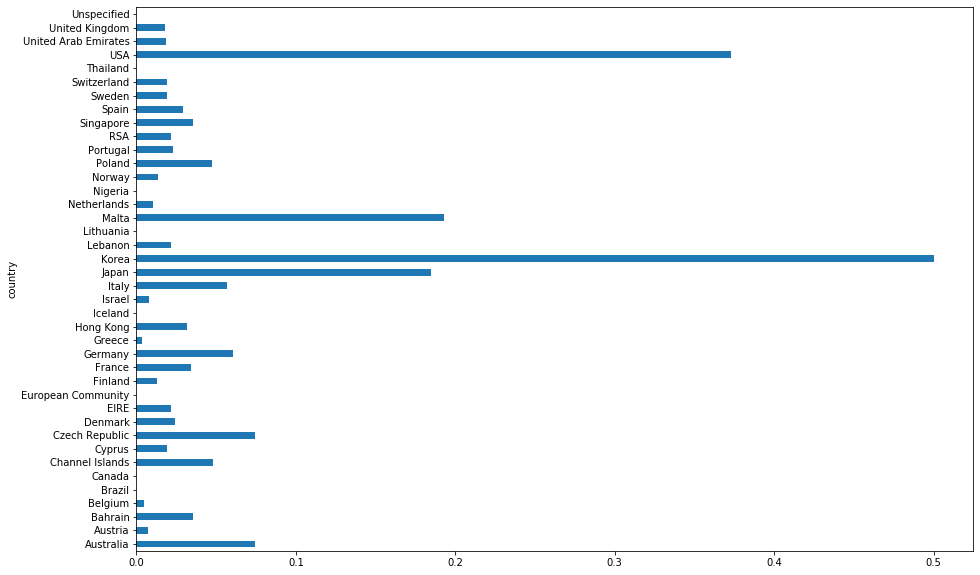

In [28]:
train.groupby('country')['is_canceled'].mean().plot(kind='barh', figsize=(15,10));

### Cleaning Data // Basic feature creation for visualization

In [47]:
# create copy of the original data
test_copy = test.copy()

## EDA

In [3]:
## read data
train = pd.read_hdf('data/train_online_retail.h5')
test = pd.read_hdf('data/test_online_retail.h5')

In [4]:
df_all = pd.concat([train, test], sort=False)

## release memory
del train, test
gc.collect()

100

In [5]:
# drop 'is test' column as it was used to split the dataset
df_all.drop(['is_test'], axis=1, inplace=True)

In [6]:
df_all['price_total_new'] = (df_all.quantity * df_all.price_unit).astype('float32')

In [7]:
def group_to_dict(group_key, agg_func=np.sum):
    train = df_all[ ~df_all['is_canceled'].isnull()]
    dict_ = train.groupby(group_key)['is_canceled'].agg(agg_func).to_dict()
    if -1 in dict_: del dict_[-1]
        
    mean = np.mean( list(dict_.values()) )
    return defaultdict(lambda: mean, dict_)

In [8]:
# count orders, canellations and cancellation ratios for a product
cnt_product_cancel = df_all['stock_code'].map(group_to_dict('stock_code'))
cnt_product_orders = df_all['stock_code'].map(group_to_dict('stock_code', agg_func=np.size))
df_all['product_cancel_to_order_ratio'] = (cnt_product_cancel / cnt_product_orders).astype('float32')

In [9]:
# get dummies
df_all = pd.get_dummies(data=df_all, prefix='stock_code', columns=['stock_code'])

In [10]:
gc.collect()

55

In [11]:
train = df_all[ ~df_all['is_canceled'].isnull() ].copy()
test = df_all[ df_all['is_canceled'].isnull() ].copy()

In [12]:
train.shape, test.shape

((520142, 5316), (547229, 5316))

In [13]:
train['is_canceled_x'] = train['is_canceled'].apply(lambda x: 0 if x == False else 1)
test['is_canceled_x'] = test['is_canceled'].apply(lambda x: -1 if np.isnan(x) else -2)

In [14]:
# group by invoice, etc and sum dummies + 'is_canceled', 'price_total'

filter_col = [col for col in df_all if col.startswith('stock_code')]
filter_col.extend(('is_canceled_x', 'quantity',
                   'product_cancel_to_order_ratio', 'price_total', 'price_total_new'))

In [15]:
train = train.groupby(['invoice', 'invoice_date', 'customer_id', 'country'])[filter_col].sum().reset_index()

In [16]:
test = test.groupby(['invoice', 'invoice_date', 'customer_id', 'country'])[filter_col].sum().reset_index()

In [17]:
train.shape, test.shape

((26858, 5314), (26853, 5314))

In [18]:
test['is_canceled_x'] = test['is_canceled_x'].apply(lambda x: np.nan if x < 0 else x)

In [19]:
train['is_canceled_x'] = train['is_canceled_x'] > 0

#### Concatanate the dataframes

In [20]:
df_all = pd.concat([train, test], sort=False)

## release memory
del train, test
gc.collect()

191

In [23]:
# rename fake is caneled column
df_all.rename(columns={'is_canceled_x': 'is_canceled'}, inplace=True)

In [24]:
def feature_extraction(df):
    
    # sort the data by the invoice number
    df = df.sort_values('invoice')
    
    # extract parts of the datetime
    df['invoice_date_no_hours'] = df.invoice_date.dt.date
    
    # calculate hours between orders
    df['invoice_date_shifted'] = df.groupby('customer_id')['invoice_date'].shift(1)
    df['hours_between_invoice'] = (df['invoice_date'] - df['invoice_date_shifted']).astype('timedelta64[h]')
    
    # create an order_placed_within x hours
    df['order_placed_within_1h'] = df['hours_between_invoice'].apply(lambda x: 1 if x < 2 else 0)
    df['order_placed_within_24h'] = df['hours_between_invoice'].apply(lambda x: 1 if x < 25 else 0)
    
    # mapping 1st ever invoice (order) to the customer id
    min_order = df.groupby('customer_id')['invoice'].min()
    min_order_dict = min_order.to_dict()

    df['first_order_per_customer'] = df.customer_id.map(min_order_dict)

    # if the invoice id is equal to the first order ever then True/False
    df['is_first_order'] = df['first_order_per_customer'] == df['invoice']
    
    # mapping last invoice (order) to the customer id
    max_order = df.groupby('customer_id')['invoice'].max()
    max_order_dict = max_order.to_dict()

    df['last_order_per_customer'] = df.customer_id.map(max_order_dict)

    # if the first invoice id is equal to the last invoice id then True/False
    df['is_the_only_order'] = df['first_order_per_customer'] == df['last_order_per_customer']
    
    # assign the same numerical values for countries from the train dataset to test dataset
    df['country_cat'] = pd.factorize( df['country'] )[0]

    # check if the order is duplicated
    df['price_total_new_rounded'] = np.around(df.price_total_new)
    df['duplicated_order'] = df.duplicated(['customer_id', 'invoice_date', 'price_total_new_rounded'], keep=False)
    
    # count orders, canellations and cancellation ratios for a customer
    df['cnt_customer_cancel'] = df['customer_id'].map(group_to_dict('customer_id'))
    df['cnt_customer_orders'] = df['customer_id'].map(group_to_dict('customer_id', agg_func=np.size))
    df['customer_cancel-to-order_ratio'] = df['cnt_customer_cancel'] / df['cnt_customer_orders']
    
    # check avg chances for cancellatoion per product for an order
    stock_col = [col for col in df_all if col.startswith('stock_code')]
    df_all['num_products_per_order'] = df_all[stock_col].sum(axis=1)
    df_all['products_cancel_chances_per_order'] = df_all['product_cancel_to_order_ratio'] / df_all['num_products_per_order']
    
    # check invoice amount above a certain treshold
    df['invoice_above_10K'] = df['price_total_new'].apply(lambda x: 1 if x > 10000 else 0)
    df['invoice_above_30K'] = df['price_total_new'].apply(lambda x: 1 if x > 30000 else 0)
    df['invoice_above_50K'] = df['price_total_new'].apply(lambda x: 1 if x > 50000 else 0)
    
    return df

In [25]:
df_all = feature_extraction(df_all)

In [26]:
df_all[ ['customer_id', 'invoice', 'quantity', 'invoice_date', 'invoice_date_shifted',
         'hours_between_invoice', 'order_placed_within_1h', 'is_canceled', 'price_total_new'] ][df_all.customer_id == 2484]

,customer_id,invoice,quantity,invoice_date,invoice_date_shifted,hours_between_invoice,order_placed_within_1h,is_canceled,price_total_new
4935,2484,9894,509,2010-04-27 16:19:00,NaT,NaN,0,NaN,1252.917969
9542,2484,19022,130,2010-09-06 10:15:00,2010-04-27 16:19:00,3161.0,0,0.0,239.281250
9504,2484,19023,1022,2010-09-06 10:19:00,2010-09-06 10:15:00,0.0,1,NaN,2383.130859
9505,2484,19024,92,2010-09-06 10:24:00,2010-09-06 10:19:00,0.0,1,NaN,162.589844
15480,2484,30828,1091,2011-01-25 13:26:00,2010-09-06 10:24:00,3387.0,0,0.0,2053.041016
17455,2484,34775,4,2011-04-04 13:03:00,2011-01-25 13:26:00,1655.0,0,0.0,4036.875000
17383,2484,34776,1,2011-04-04 13:04:00,2011-04-04 13:03:00,0.0,1,NaN,2054.000000
17456,2484,34777,4,2011-04-04 13:08:00,2011-04-04 13:04:00,0.0,1,1.0,4036.875000
17384,2484,34778,1,2011-04-04 13:09:00,2011-04-04 13:08:00,0.0,1,NaN,2054.000000
17483,2484,34837,1384,2011-04-05 10:58:00,2011-04-04 13:09:00,21.0,0,0.0,2118.835449


In [27]:
df_all[ ['customer_id', 'invoice', 'quantity', 'invoice_date', 'invoice_date_shifted',
         'hours_between_invoice', 'order_placed_within_1h', 'is_canceled', 'price_total_new'] ][df_all.customer_id == 2056]

,customer_id,invoice,quantity,invoice_date,invoice_date_shifted,hours_between_invoice,order_placed_within_1h,is_canceled,price_total_new
3644,2056,7310,1,2010-03-19 11:30:00,NaT,NaN,0,NaN,6960.0
3672,2056,7311,1,2010-03-19 11:35:00,2010-03-19 11:30:00,0.0,1,0.0,6960.0
3645,2056,7313,1,2010-03-19 11:45:00,2010-03-19 11:35:00,0.0,1,NaN,6960.0
3674,2056,7314,1,2010-03-19 11:49:00,2010-03-19 11:45:00,0.0,1,1.0,6960.0
3675,2056,7316,1,2010-03-19 11:53:00,2010-03-19 11:49:00,0.0,1,1.0,5796.0


In [28]:
def get_feats(df):
    feats = df.select_dtypes([np.number, np.bool]).columns
    black_list = ['is_canceled', 'invoice', 'price_total', 'first_order_per_customer', 'last_order_per_customer',
                  'hours_between_invoice', 'price_total_new_rounded']
    return [x for x in feats if x not in black_list]

In [29]:
# prepare to train
train = df_all[ ~df_all['is_canceled'].isnull() ].copy()
test = df_all[ df_all['is_canceled'].isnull() ].copy()

#release memory
del df_all
gc.collect()

88

In [44]:
train['price_total_log'] = np.log1p(train['price_total_new'].values)
test['price_total_log'] = np.log1p(test['price_total_new'].values)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


In [30]:
#get feats
feats = get_feats(train)

In [33]:
feats[-15:]

['quantity',
 'product_cancel_to_order_ratio',
 'price_total_new',
 'order_placed_within_1h',
 'order_placed_within_24h',
 'is_first_order',
 'is_the_only_order',
 'country_cat',
 'duplicated_order',
 'cnt_customer_cancel',
 'cnt_customer_orders',
 'customer_cancel-to-order_ratio',
 'invoice_above_10K',
 'invoice_above_30K',
 'invoice_above_50K']

In [62]:
clf_feats = ['price_total_log',
             #'cnt_customer_cancel',
             #'cnt_customer_orders',
             'customer_cancel-to-order_ratio',
             #'num_products_per_order',
             'product_cancel_to_order_ratio',
             'duplicated_order',
             'order_placed_within_1h',
             'quantity',
             #'country_cat', 
             'customer_id'
            ]

In [63]:
X = train[clf_feats].values
y = train['is_canceled'].astype('int8').values

In [65]:
# define model
model = xgb.XGBClassifier(max_depth=6, n_estimators=100, learning_rate=0.4, random_state=random_state)
# define evaluation procedure
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_state)
# evaluate model
scores = cross_val_score(model, X, y, scoring='recall', cv=rskf)
# summarize performance
print('Mean Recall: %.5f' % np.mean(scores))

Mean Recall: 0.83040


In [66]:
model.fit(X, y)
y_pred = model.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     22711
           1       0.96      0.93      0.94      4147

   micro avg       0.98      0.98      0.98     26858
   macro avg       0.97      0.96      0.97     26858
weighted avg       0.98      0.98      0.98     26858



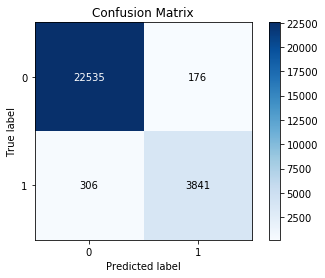

In [67]:
ax = plot_confusion_matrix(y, y_pred)

# correcting cut edges
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

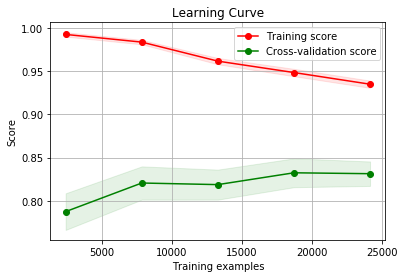

In [68]:
skplt.estimators.plot_learning_curve(model, X, y, cv=rskf, scoring='recall');

In [69]:
perm = PermutationImportance(model, random_state=random_state).fit(X, y)
eli5.show_weights(perm, feature_names=clf_feats)

Weight,Feature
0.1205 ± 0.0032,price_total_log
0.0992 ± 0.0017,quantity
0.0675 ± 0.0019,customer_cancel-to-order_ratio
0.0431 ± 0.0010,product_cancel_to_order_ratio
0.0227 ± 0.0015,customer_id
0.0153 ± 0.0007,order_placed_within_1h
-0.0001 ± 0.0003,duplicated_order


In [70]:
eli5.show_weights(model.get_booster(), feature_names=clf_feats, top=20)

Weight,Feature
0.3810,quantity
0.3014,customer_cancel-to-order_ratio
0.1571,order_placed_within_1h
0.0552,price_total_log
0.0534,product_cancel_to_order_ratio
0.0365,customer_id
0.0154,duplicated_order


In [71]:
eli5.explain_weights_xgboost(model.get_booster(), feature_names=clf_feats, top=20, importance_type='cover' )

Weight,Feature
0.2476,duplicated_order
0.1829,customer_cancel-to-order_ratio
0.1492,quantity
0.1237,price_total_log
0.1225,product_cancel_to_order_ratio
0.0979,customer_id
0.0763,order_placed_within_1h


In [72]:
eli5.explain_weights_xgboost(model.get_booster(), feature_names=clf_feats, top=20, importance_type='weight' )

Weight,Feature
0.2575,price_total_log
0.2529,product_cancel_to_order_ratio
0.1651,customer_id
0.1489,quantity
0.1381,customer_cancel-to-order_ratio
0.0352,order_placed_within_1h
0.0023,duplicated_order


In [55]:
train['is_canceled_predict'] = y_pred
train['total_return'] = train['price_total_new'] * train['is_canceled']
train['total_return_predict'] = train['price_total_new'] * train['is_canceled_predict']

In [56]:
mse(train['total_return'], train['total_return_predict'])

43011.479332951676

In [57]:
X_test = test[clf_feats].values

model.fit(X, y)
y_test_pred = model.predict(X_test)

In [58]:
test['is_canceled'] = y_test_pred
test['total_return'] = test['price_total_new'] * test['is_canceled']

In [59]:
## przygotowujemy do submit
result = test.groupby('invoice')['total_return'].agg(np.sum).to_frame().reset_index()
result[ ['invoice', 'total_return'] ].to_csv('results/submit_4_10-04-2020.csv', index=False)

In [61]:
test[ ['customer_id', 'invoice_date', 'price_total_new', 'is_canceled'] ][test.price_total_new > 5000]

,customer_id,invoice_date,price_total_new,is_canceled
235,-1,2009-12-04 09:43:00,6529.135742,0
400,-1,2009-12-07 17:56:00,6370.618164,0
755,-1,2009-12-14 17:16:00,6342.499023,0
871,-1,2009-12-16 17:01:00,6034.719727,0
992,-1,2009-12-18 17:06:00,5534.002930,0
1269,3,2010-01-08 10:09:00,6624.000000,0
1366,3,2010-01-12 15:57:00,18532.996094,0
1367,3,2010-01-12 16:02:00,6711.865234,0
1555,-1,2010-01-19 17:49:00,7986.688477,0
1596,-1,2010-01-20 17:50:00,5750.629883,0


In [231]:
X = train[feats].values
y = train['is_canceled'].astype('int8').values

In [233]:
def objective(space):
    rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_state)
    
    model = xgb.XGBClassifier(n_estimators = space['n_estimators'],
                              max_depth = int(space['max_depth']),
                              min_child_weight = space['min_child_weight'],
                              scale_pos_weight = space['scale_pos_weight'],
                              subsample = space['subsample'],
                              learning_rate = space['learning_rate'],
                              gamma = space['gamma'],
                              colsample_bytree = space['colsample_bytree'],
                              random_state=random_state,
                             n_jobs=-1)
    
    for train_idx, test_idx in rskf.split(X, y):

        eval_set  = [(X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])]
        model.fit(X[train_idx], y[train_idx], eval_set=eval_set, eval_metric = 'aucpr', early_stopping_rounds=10, verbose=False)
        y_pred = model.predict(X[test_idx])

        score = roc_auc_score(y[test_idx], y_pred)
    
        print("SCORE: {0}".format(score))
        return{'loss': 1-score, 'status': STATUS_OK }
    
    
space ={
        'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
        'min_child_weight': hp.quniform ('min_child', 1, 10, 1),
        'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 50),
        'subsample': hp.uniform ('subsample', 0.7, 1),
        'n_estimators' : hp.choice('n_estimators', np.arange(10, 1000, 2, dtype=int)),
        'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
    }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best)

SCORE: 0.9300801798744274                             
SCORE: 0.9268125318174106                                                           
SCORE: 0.9407368912268794                                                           
SCORE: 0.9359886730018667                                                            
SCORE: 0.9278418250466655                                                            
SCORE: 0.9469810580349567                                                          
SCORE: 0.9091066731715596                                                          
SCORE: 0.9353173256405904                                                         
SCORE: 0.9191965043271679                                                         
SCORE: 0.941352558119803                                                            
100%|██████████| 10/10 [1:08:53<00:00, 405.54s/trial, best loss: 0.05301894196504331]
The best params:  {'colsample_bytree': 0.75, 'gamma': 0.7000000000000001, 'learning_rate': 0.35000

In [234]:
model.fit(X, y)
y_pred = model.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     22711
           1       0.90      0.89      0.90      4147

   micro avg       0.97      0.97      0.97     26858
   macro avg       0.94      0.94      0.94     26858
weighted avg       0.97      0.97      0.97     26858



In [235]:
train['is_canceled_predict'] = y_pred

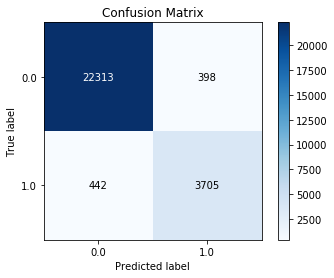

In [237]:
ax = plot_confusion_matrix(train.is_canceled, train.is_canceled_predict)

# correcting cut edges
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);